In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl

sys.path.append('models')
from sim_cosmology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform2d import DWT2d
from utils import get_2dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_2dreconstruct, plot_2dfilts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data and model

In [2]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p, img_size=256)

# # check prediction
# with torch.no_grad():
#     result = {'y': [], 'pred': []}
#     for data, params in train_loader:
#         result['y'].append(params[:,1].detach().cpu())
#         result['pred'].append(model(data.to(device))[:,1].detach().cpu())
# plt.scatter(torch.cat(result['y']), torch.cat(result['pred']))
# plt.xlabel('true param')
# plt.ylabel('predicted param')
# plt.show()  

## initialize filter

In [34]:
import pywt

In [39]:
x = im[0,0,...]
x = x.detach().cpu().numpy()

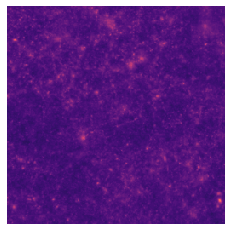

In [42]:
cshow(x)

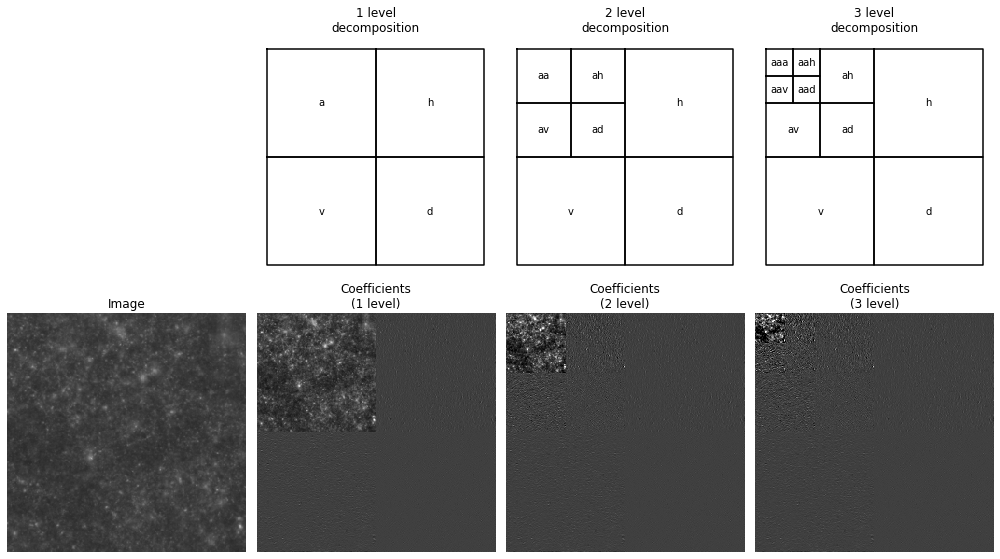

In [50]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

shape = x.shape

max_lev = 3       # how many levels of decomposition to draw
label_levels = 3  # how many levels to explicitly label on the plots

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        # show the original image before decomposition
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray, vmax=0.15, vmin=-0.05)
        axes[1, 0].set_title('Image')
        axes[1, 0].set_axis_off()
        continue

    # plot subband boundaries of a standard DWT basis
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    # compute the 2D DWT
    c = pywt.wavedec2(x, 'db2', mode='periodization', level=level)
    # normalize each coefficient array independently for better visibility
#     c[0] /= np.abs(c[0]).max()
#     for detail_level in range(level):
#         c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    # show the normalized coefficients
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray, vmax=0.15, vmin=-0.05)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

In [3]:
# get image
torch.manual_seed(p.seed)
im = iter(test_loader).next()[0][0:64].to(device)

# wavelet transform 
wt = DWT2d(wave='db5', mode='symmetric', J=5, init_factor=0, noise_factor=0.1).to(device)

im_t = wt(im)
recon = wt.inverse(im_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - im)**2/im.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

Reconstruction error=16.85218


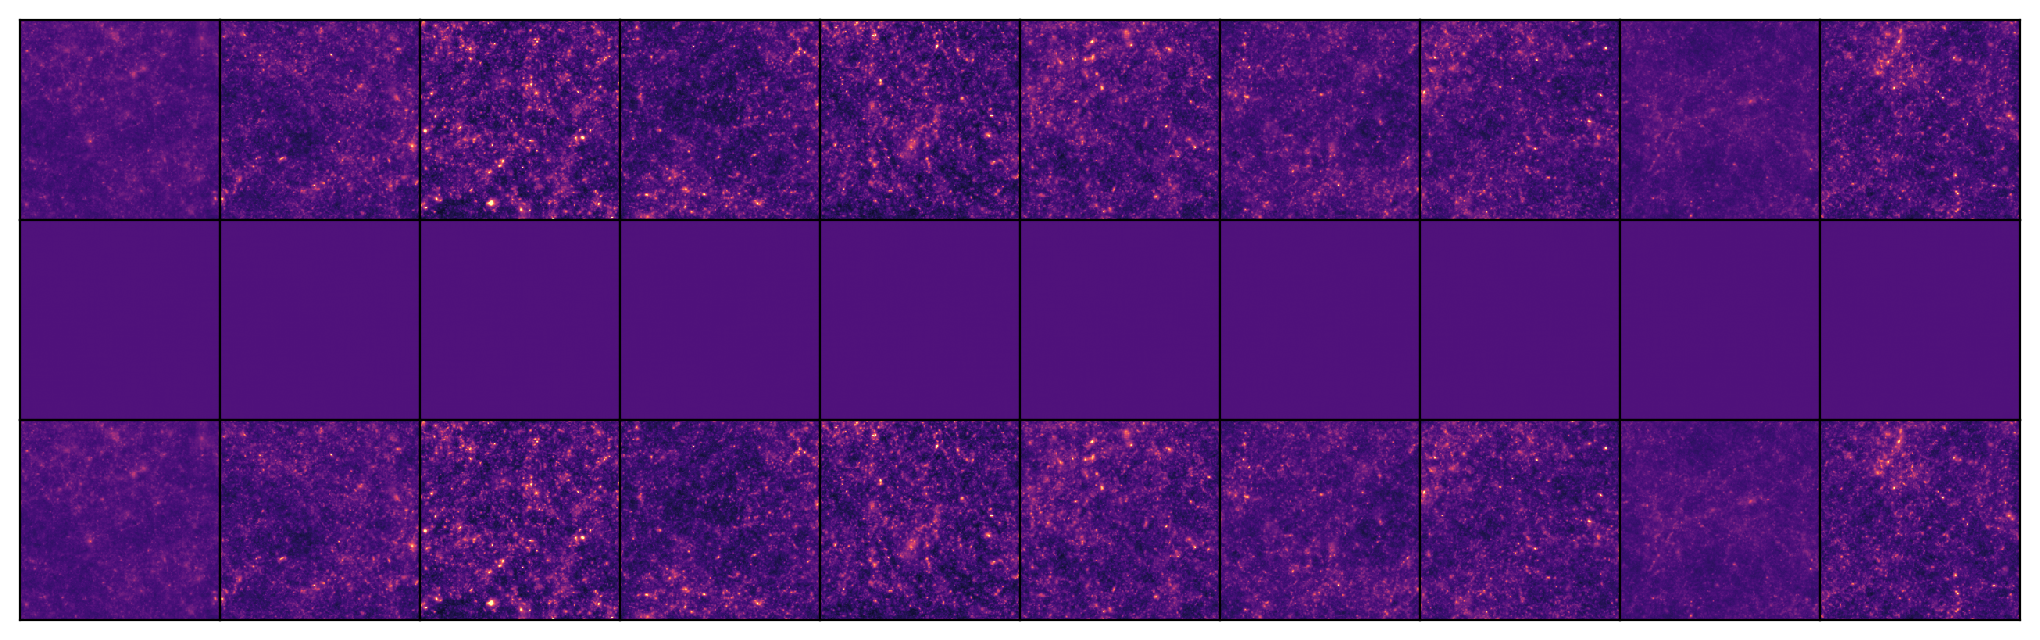

In [4]:
# plot original and reconstruction images
plot_2dreconstruct(im, recon)

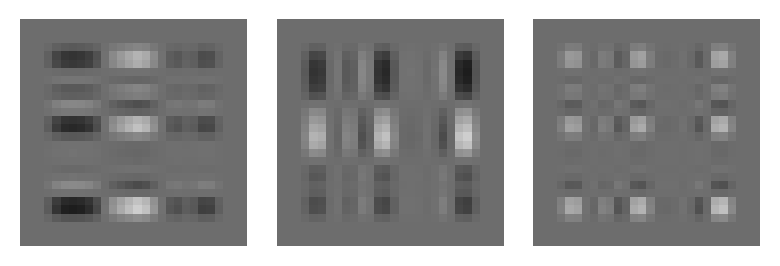

In [5]:
# plot wavelet filters
plot_2dfilts(filt, figsize=(4,4), share_min_max=True)

## optimize filter

In [6]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.005)
loss_f = get_loss_f(lamL1attr=10)
trainer = Trainer(model, wt, Attributer, optimizer, loss_f, attr_methods='Saliency', device=device)

In [7]:
trainer(train_loader, epochs=50)

Starting Training Loop...
Train Epoch: 0 [15600/25000 (100%)]	Loss: 496.830078
====> Epoch: 0 Average train loss: 324.4289
Train Epoch: 1 [15600/25000 (100%)]	Loss: 850.034424
====> Epoch: 1 Average train loss: 635.7446
Train Epoch: 2 [15600/25000 (100%)]	Loss: 860.010742
====> Epoch: 2 Average train loss: 918.0301
Train Epoch: 3 [15600/25000 (100%)]	Loss: 1006.369690
====> Epoch: 3 Average train loss: 938.8173
Train Epoch: 4 [15600/25000 (100%)]	Loss: 1022.176086
====> Epoch: 4 Average train loss: 939.2738
Train Epoch: 5 [15600/25000 (100%)]	Loss: 954.417053
====> Epoch: 5 Average train loss: 939.0904
Train Epoch: 6 [15600/25000 (100%)]	Loss: 941.156067
====> Epoch: 6 Average train loss: 938.9051
Train Epoch: 7 [15600/25000 (100%)]	Loss: 937.074219
====> Epoch: 7 Average train loss: 938.7403
Train Epoch: 8 [15600/25000 (100%)]	Loss: 906.765259
====> Epoch: 8 Average train loss: 938.5680
Train Epoch: 9 [15600/25000 (100%)]	Loss: 956.344971
====> Epoch: 9 Average train loss: 938.4917
Tr

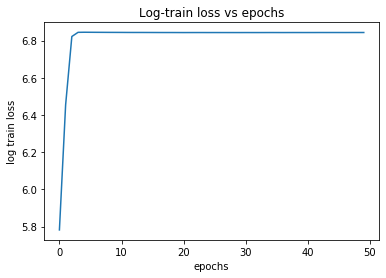

In [18]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [9]:
im_t = wt(im)
recon = wt.inverse(im_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - im)**2/im.size(0)))

# get 2d wavelet filters
filt = get_2dfilts(wt)

Reconstruction error=0.00000


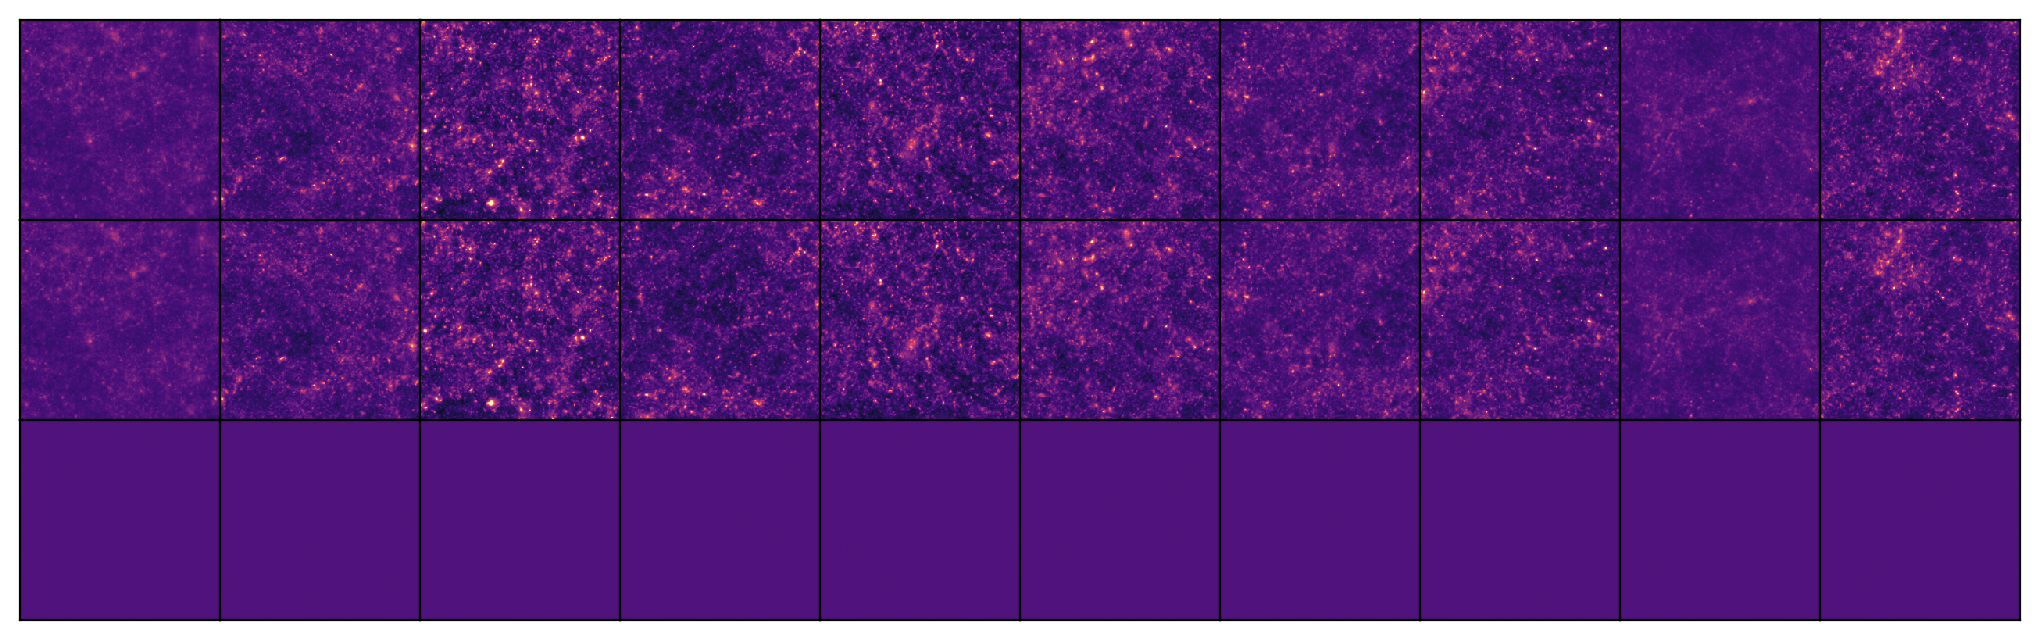

In [20]:
# plot original and reconstruction images
plot_2dreconstruct(im, recon)

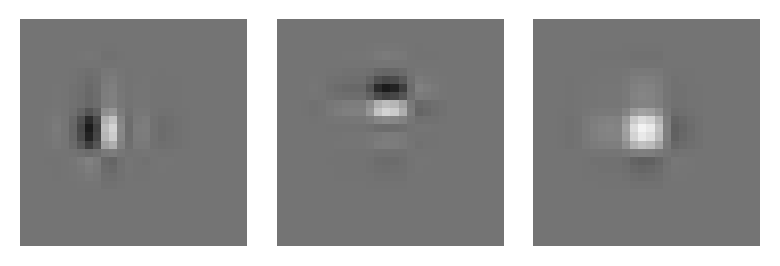

In [21]:
# plot wavelet filters
plot_2dfilts(filt, figsize=(4,4), share_min_max=True)

## test error

In [12]:
loss_v = get_loss_f(lamL1attr=1)

# validator 
validator = Validator(model, wt, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss, L1attr_loss = validator(test_loader)

# original wavelet transform
wt_o = DWT2d(wave='db5', mode='symmetric', J=5, init_factor=1, noise_factor=0).to(device)
validator_o = Validator(model, wt_o, Attributer, loss_v, attr_methods='Saliency', device=device)
_, rec_loss_o, L1attr_loss_o = validator_o(test_loader)

print("\n\n Original filter:Reconstruction Error={:.5f} L1attribution loss={:.5f} \n Adaptive filter:Reconstruction Error={:.5f} L1attribution loss={:.5f}"\
          .format(rec_loss_o, L1attr_loss_o, rec_loss, L1attr_loss))

Test: [496/2000 (97%)]	Loss: 141.5456706

 Original filter:Reconstruction Error=0.00000 L1attribution loss=140.84485 
 Adaptive filter:Reconstruction Error=0.00000 L1attribution loss=93.80355


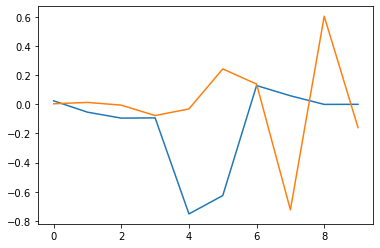

In [15]:
plt.plot(wt.h1.data.squeeze().detach().cpu())
plt.plot(wt_o.h1.data.squeeze().detach().cpu())

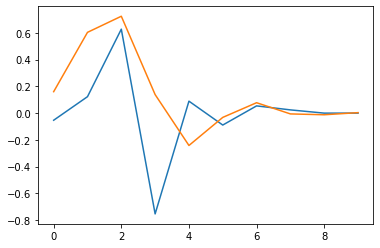

In [16]:
plt.plot(wt.h0.data.squeeze().detach().cpu())
plt.plot(wt_o.h0.data.squeeze().detach().cpu())